# **Библиотеки**

In [ ]:
!pip install nltk scikit-learn
!pip install pymorphy2
import requests
import json
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import WordNetLemmatizer
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pymorphy2
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold,StratifiedKFold,LeaveOneOut, cross_val_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch.nn as nn
from tqdm import tqdm
import time
from sklearn.metrics import accuracy_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 950.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 56.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=2970faac42d0189d926a288cffd416f5daa1ca40616518d52bf1cec43ff43585
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
device = torch.device('cuda')

# **Задание 2**

Примените один из трансформеров, например BERT к задаче классификации отзывов клиентов. Сравните полученные результаты с классическими методами машинного обучения, с RNN. Сделайте выводы.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Чтение данных из CSV файла
df = pd.read_csv("/content/drive/MyDrive/NLP/bankReviews.csv")
df.head()

,description,name,reviewRating,bank
0,Я оформила кредитную карту по рекомендации но ...,"Деньги вам и другу, не отвечают на сообщения",1.0,alfabank
1,Добрый день столкнулся с проблемой верного на...,Проблемы с начислением кэшбэка,2.0,alfabank
2,За сентябрь у меня выпал кэшбэк 5 на супермар...,Не начислили кэшбэк,1.0,alfabank
3,ul li 25 09 2023 решила поменять банк и по...,Альфа банк нагло врет,1.0,alfabank
4,ID вопроса 518688 данный вопрос не решается уж...,Полное игнрирование,1.0,alfabank


# Предпроцессинг данных

In [ ]:
# Инициализируем объект для лемматизации
morph = pymorphy2.MorphAnalyzer()

# Загрузите список стоп-слов для русского языка
stopWords = set(stopwords.words('russian'))

# Функция для предобработки текста
def preprocess_text(text):
    # Удалить все символы, кроме букв
    text = re.sub(r'[^а-яА-Я\s]', '', text)

    # Разбить текст на токены
    tokens = text.split()

    # Очистить текст от стоп-слов
    tokens = [token for token in tokens if token not in stopWords]

    # Объединить токены обратно в текст
    return ' '.join(tokens)

# Применяем предобработку к столбцам 'description' и 'name'
df.dropna(inplace=True)
df['description'] = df['description'].apply(preprocess_text)
df['name'] = df['name'].apply(preprocess_text)
df.head()

,description,name,reviewRating,bank
0,Я оформила кредитную карту рекомендации смогла...,Деньги другу отвечают сообщения,1.0,alfabank
1,Добрый день столкнулся проблемой верного начис...,Проблемы начислением кэшбэка,2.0,alfabank
2,За сентябрь выпал кэшбэк супермаркеты сентября...,Не начислили кэшбэк,1.0,alfabank
3,решила поменять банк рекомендации лояльный выг...,Альфа банк нагло врет,1.0,alfabank
4,вопроса данный вопрос решается сентября это ба...,Полное игнрирование,1.0,alfabank


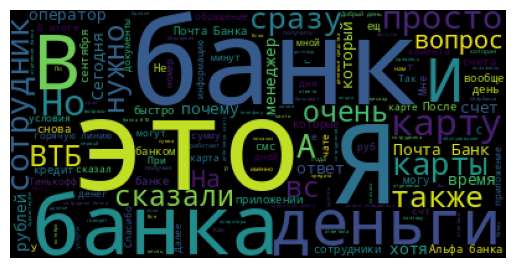

In [ ]:
# Создаем облако слов
wordcloud = WordCloud().generate(' '.join(df['description']))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Визуализация данных

<ipython-input-7-fe22259ee3d6>:3: UserWarning: The palette list has more values (8) than needed (5), which may not be intended.
  sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)


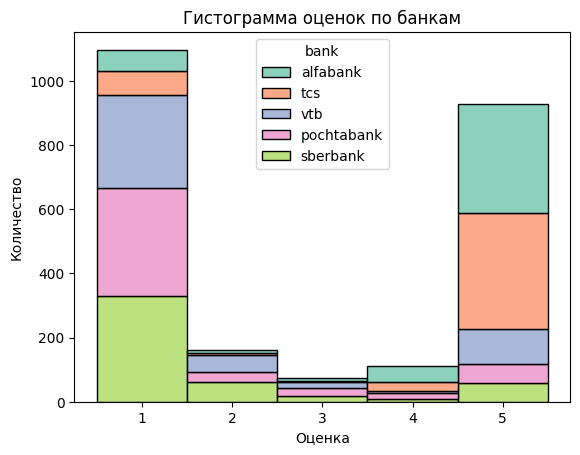

In [ ]:
custom_palette = sns.color_palette("Set2")

sns.histplot(data=df, x="reviewRating", hue="bank", multiple="stack", discrete=True, palette=custom_palette)

plt.xlabel("Оценка")
plt.ylabel("Количество")
plt.title("Гистограмма оценок по банкам")

plt.show()

In [ ]:
y = df['reviewRating']
X = df.drop('reviewRating', axis = 1)
X.head()

,description,name,bank
0,Я оформила кредитную карту рекомендации смогла...,Деньги другу отвечают сообщения,alfabank
1,Добрый день столкнулся проблемой верного начис...,Проблемы начислением кэшбэка,alfabank
2,За сентябрь выпал кэшбэк супермаркеты сентября...,Не начислили кэшбэк,alfabank
3,решила поменять банк рекомендации лояльный выг...,Альфа банк нагло врет,alfabank
4,вопроса данный вопрос решается сентября это ба...,Полное игнрирование,alfabank


In [ ]:
# Проверяем наличие пропущенных значений в X
missing_values = X.isnull().sum()
print("Количество пропущенных значений в X:")
print(missing_values)

# Проверяем наличие пропущенных значений в y
missing_values_y = y.isnull().sum()
print("Количество пропущенных значений в y:")
print(missing_values_y)

Количество пропущенных значений в X:
description    0
name           0
bank           0
dtype: int64
Количество пропущенных значений в y:
0


In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df['description'], df['reviewRating'], test_size=0.2, random_state=42)

# Bert

In [ ]:
# BERT для анализа тональности
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=6)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Описание модели
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

<Axes: >

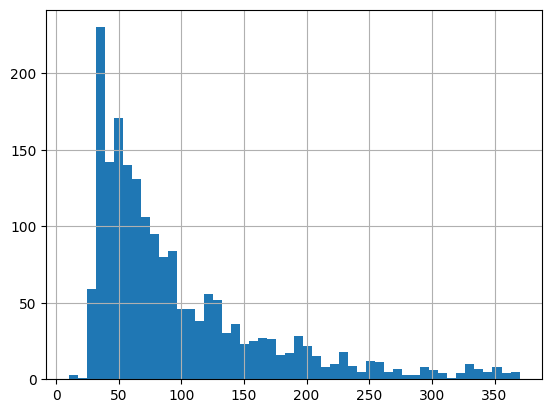

In [ ]:
seq_len = [len(str(i).split()) for i in X_train]
pd.Series(seq_len).hist(bins = 50)

In [ ]:
X_train = X_train.astype(str)
X_test = X_test.astype(str)

texts_train = X_train.values.tolist()
texts_test = X_test.values.tolist()

tokens_train = tokenizer.batch_encode_plus(
    texts_train,
    max_length=35,
    padding='max_length',
    truncation=True
)

tokens_test = tokenizer.batch_encode_plus(
    texts_test,
    max_length=35,
    padding='max_length',
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(y_train.values.astype(np.float64))

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(y_test.values.astype(np.float64))

batch_size = 4
train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)

test_data =  TensorDataset(test_seq, test_mask, test_y)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
cross_entropy = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
device

device(type='cuda')

In [ ]:
epochs = 10
predictions_labels = []

for epoch in range(epochs):
  model.train()
  for batch in tqdm(train_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch
    optimizer.zero_grad()
    outputs = model(input_ids, attention_mask=attention_mask)
    loss = cross_entropy(outputs.logits, labels.long())
    loss.backward()
    optimizer.step()

  # Оценка производительности модели на тестовом наборе
  correct = 0
  total = 0
  model.eval()
  predictions = []
  for batch in tqdm(test_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, attention_mask, labels = batch
    with torch.no_grad():
      outputs = model(input_ids, attention_mask=attention_mask)
      logits = outputs.logits
      predictions.extend(logits.argmax(dim=-1).cpu().detach().numpy())

      # Подсчет точности
      total += labels.size(0)
      correct += (logits.argmax(dim=-1) == labels.to(device)).sum().item()

  predictions_labels.append(predictions)
  accuracy = 100 * correct / total
  print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss:.4f}, Test Accuracy: {accuracy:.2f}%')

# Вывод результатов после завершения всех эпох
print("Training finished. Test accuracy:", accuracy)

100%|██████████| 119/119 [00:01<00:00, 61.76it/s]


Epoch [1/10], Loss: 0.0023, Test Accuracy: 57.26%


100%|██████████| 119/119 [00:01<00:00, 79.34it/s]


Epoch [2/10], Loss: 0.0001, Test Accuracy: 61.26%


100%|██████████| 119/119 [00:01<00:00, 78.35it/s]


Epoch [3/10], Loss: 0.0005, Test Accuracy: 60.21%


100%|██████████| 119/119 [00:01<00:00, 77.62it/s]


Epoch [4/10], Loss: 0.7167, Test Accuracy: 60.84%


100%|██████████| 119/119 [00:01<00:00, 70.82it/s]


Epoch [5/10], Loss: 0.0003, Test Accuracy: 59.37%


100%|██████████| 119/119 [00:02<00:00, 49.16it/s]


Epoch [6/10], Loss: 0.0002, Test Accuracy: 57.05%


100%|██████████| 119/119 [00:05<00:00, 22.09it/s]


Epoch [7/10], Loss: 0.0006, Test Accuracy: 58.95%


100%|██████████| 119/119 [00:01<00:00, 75.58it/s]


Epoch [8/10], Loss: 0.0005, Test Accuracy: 57.05%


100%|██████████| 119/119 [00:01<00:00, 75.40it/s]


Epoch [9/10], Loss: 0.0029, Test Accuracy: 61.47%


100%|██████████| 119/119 [00:01<00:00, 62.05it/s]

Epoch [10/10], Loss: 0.0003, Test Accuracy: 61.89%
Training finished. Test accuracy: 61.89473684210526


**Вывод:**

* Потери (Loss) на обучающем наборе (train) уменьшаются, что может свидетельствовать о том, что модель обучается.
* Тем не менее, точность на тестовом наборе (Test Accuracy) может не улучшаться или ухудшаться после некоторого времени, что может указывать на возможное переобучение или другие проблемы.

Перед нами сложная модель и наших данных мало для её успешного обучения, поэтому в нашем случае она переобучается.

In [ ]:
set(predictions)

{1, 2, 3, 4, 5}

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(test_y, predictions_labels[-1])
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.6189


In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(test_y, predictions_labels[-1])
cm

array([[147,  10,   5,   1,  40],
       [ 24,   0,   0,   1,   5],
       [  7,   2,   0,   0,   6],
       [ 11,   2,   1,   0,  14],
       [ 45,   3,   1,   3, 147]])

In [ ]:
from sklearn.metrics import classification_report

cr = classification_report(test_y, predictions_labels[-1])
print(cr)

              precision    recall  f1-score   support

         1.0       0.63      0.72      0.67       203
         2.0       0.00      0.00      0.00        30
         3.0       0.00      0.00      0.00        15
         4.0       0.00      0.00      0.00        28
         5.0       0.69      0.74      0.72       199

    accuracy                           0.62       475
   macro avg       0.26      0.29      0.28       475
weighted avg       0.56      0.62      0.59       475



**Вывод:** мы имеем очень маленькую точность, объём наших данных не подходит для такой сложной модели.

In [ ]:
torch.save(model.state_dict(), 'bert_model_reviews_weights.pth')

In [ ]:
sentence = input("Введите отзыв: ")
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=-1).item()

print("Предсказанная оценка отзыва:", prediction)

Введите отзыв: Ужасный банк!
Предсказанная оценка отзыва: 1


In [ ]:
sentence = input("Введите отзыв: ")
inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

model.eval()
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)

logits = outputs.logits
prediction = torch.argmax(logits, dim=-1).item()

print("Предсказанная оценка отзыва:", prediction)

Введите отзыв: Хороший банк!
Предсказанная оценка отзыва: 5


# **Задание 3**

Примените один из трансформеров, например BERT, к задаче генерации англоязычного и русскоязычного текстов. Сравните результаты с LSTM. Сделайте выводы.

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Загрузка предобученной модели GPT-2 и токенизатора
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')
model = GPT2LMHeadModel.from_pretrained('sberbank-ai/rugpt3small_based_on_gpt2')

tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [ ]:
# Пример генерации русского текста
prompt = input("Введите фразу: ")
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Генерация текста с использованием модели
output = model.generate(input_ids, max_length=100, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7)

# Декодирование сгенерированного текста
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Сгенерированный текст:", generated_text)

Введите фразу: Однажды, в далекой-далекой стране
Сгенерированный текст: Однажды, в далекой-далекой стране, когда-то давным-давно, жил-был маленький мальчик.  Он был очень хорош собой и очень любил играть в прятки с другими мальчишками. 
 И вот однажды, он увидел, что на улице идет дождь, и ему захотелось спрятаться от него, но он не мог этого сделать, потому что не знал, где он находится и что с ним делать, поэтому он решил спрятаться в каком-нибудь укромном месте и спрятаться там, пока не


In [ ]:
# Пример генерации английского текста
prompt = input("Введите фразу: ")
input_ids = tokenizer.encode(prompt, return_tensors="pt")

# Генерация текста с использованием модели
output = model.generate(input_ids, max_length=100, num_beams=5, no_repeat_ngram_size=2, top_k=50, top_p=0.95, temperature=0.7)

# Декодирование сгенерированного текста
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
print("Сгенерированный текст:", generated_text)

Введите фразу: Once upon a time, in a land far, far away
Сгенерированный текст: Once upon a time, in a land far, far away from the city, a young man, who had been born on the island, was killed by a group of men.

In the aftermath of the battle, the two men were taken to the town, where they remained until the next day, when they were found dead. They were buried in the churchyard of St. John the Baptist Church, which was the site of a massacre. In the


**Вывод:** gpt2 показывает отличные результаты, что не сравнится с lstm. Наша модель lstm обучалась в условии ограниченных ресурсов, поэтому, конечно же, от неё не стоит ожидать таких хороших результатов.

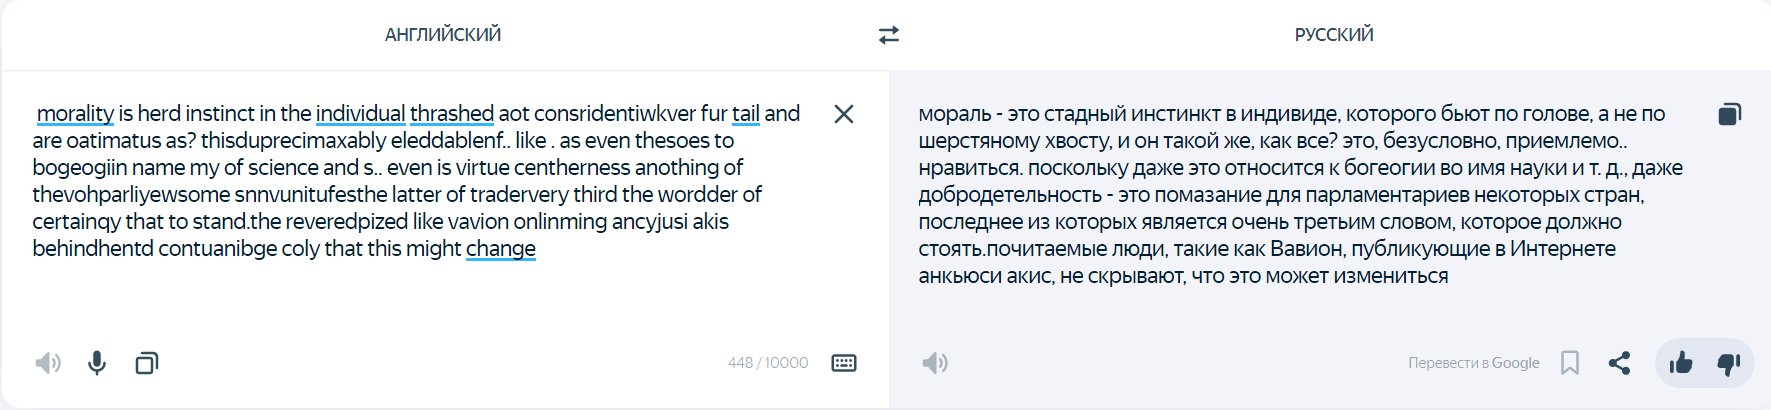

# **Задание 4**

Примените один из трансформеров, например BERT, к задаче машинного перевода.

In [1]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.7 MB/s eta 0:00:00


# AutoModelForSeq2SeqLM

In [9]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Загрузка предобученной модели и токенизатора для машинного перевода
model_name = "Helsinki-NLP/opus-mt-ru-en"  # рус->англ
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:197: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")


In [10]:
text_to_translate = input("Введите текст для перевода: ")
inputs = tokenizer(text_to_translate, return_tensors="pt")
outputs = model.generate(**inputs)
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Переведенный текст: ", translated_text)

Введите текст для перевода: Вау, что за чудесная погода сегодня!
Переведенный текст:  Wow, what a wonderful weather today!


# MarianMTModel

In [11]:
from transformers import MarianMTModel, MarianTokenizer

# Загрузка предобученной модели и токенизатора для машинного перевода
model_name = "Helsinki-NLP/opus-mt-en-ru"  # англ->рус
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [12]:
text_to_translate = input("Введите текст для перевода: ")
inputs = tokenizer(text_to_translate, return_tensors="pt")
outputs = model.generate(**inputs)
translated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
print("Переведенный текст: ", translated_text)

Введите текст для перевода: Wow, what a wonderful weather today!
Переведенный текст:  Ого, какая прекрасная погода сегодня!


**Вывод:** видим, что модели отлично обучены переводить текст, не искажая его смысл.